In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

Loaded data:
                 Sales  Temperature     Demand
Date                                         
2023-01-01  56.641805    30.443854  40.530161
2023-01-02  57.945924    30.732893  44.558614
2023-01-03  65.999173    31.341150  52.815069
2023-01-04  73.985583    31.397814  59.329409
2023-01-05  68.159791    29.052155  53.177637
Selected Lag Order:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        10.25       10.30   2.830e+04       10.27
1        6.843       7.060       937.5       6.931
2        6.599      6.979*       734.7       6.753
3        6.534       7.077       688.4       6.754
4        6.462       7.167       640.9      6.748*
5        6.418       7.286       613.6       6.770
6       6.372*       7.403      586.6*       6.790
7        6.423       7.616       618.2       6.907
8        6.457       7.813       641.0       7.007
9        6.396       7.915     

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


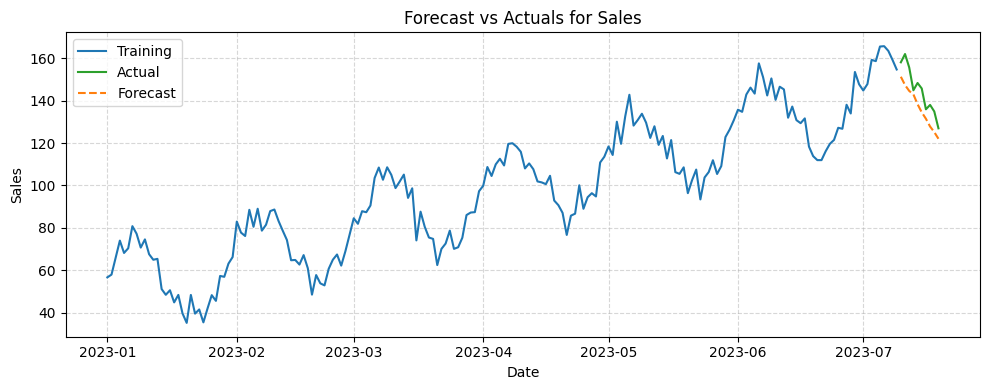

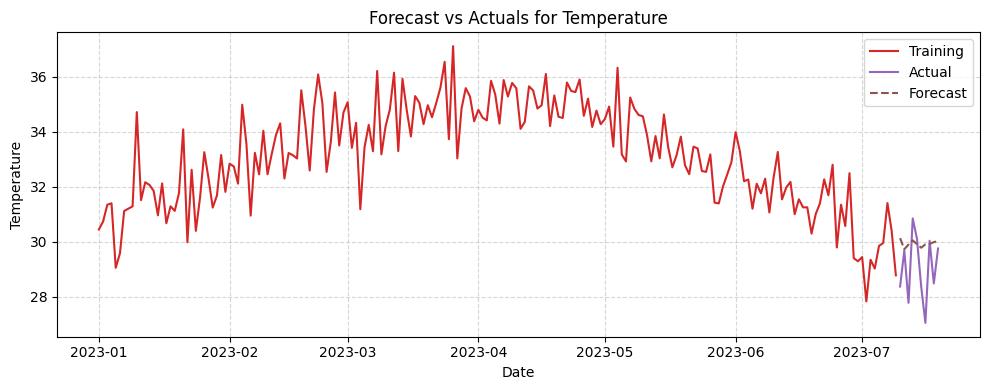

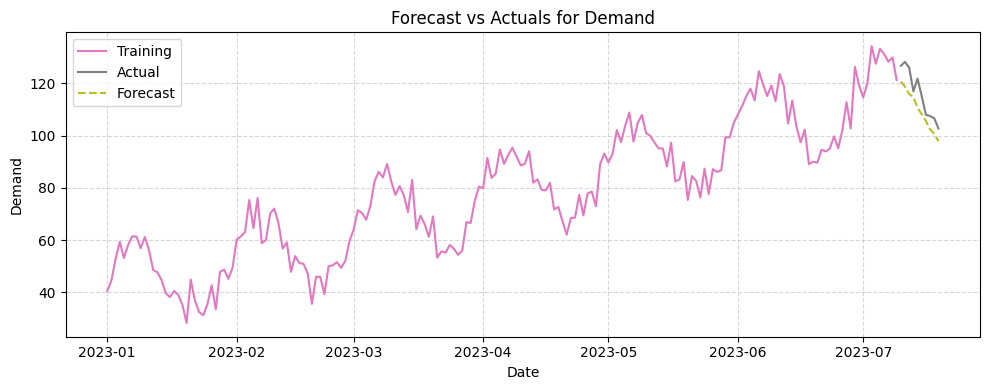

RMSE for Sales: 9.26
RMSE for Temperature: 1.44
RMSE for Demand: 7.06


In [5]:
# === Step 1: Load and Preprocess Data ===
df = pd.read_csv('/content/multivariate_time_series.csv', parse_dates=['Date'], index_col='Date')
print("Loaded data:\n", df.head())

# Ensure all values are numeric
df = df.astype(float)

# === Step 2: Split into Train/Test Sets ===
n_obs = 10  # last N observations for testing
train, test = df[:-n_obs], df[-n_obs:]

# === Step 3: Fit VAR Model ===
model = VAR(train)
lag_order = model.select_order(maxlags=15)
print("Selected Lag Order:\n", lag_order.summary())

model_fitted = model.fit(lag_order.aic)
print(model_fitted.summary())

# === Step 4: Forecast ===
forecast_input = train.values[-model_fitted.k_ar:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_obs)

# === Step 5: Convert Forecast to DataFrame ===
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)
print("\nForecast:\n", forecast_df)

# === Step 6: Plot Forecast vs Actual ===
import matplotlib.pyplot as plt

# Color palette options
color_sets = [
    ('#1f77b4', '#2ca02c', '#ff7f0e'),  # Blue, Green, Orange
    ('#d62728', '#9467bd', '#8c564b'),  # Red, Purple, Brown
    ('#e377c2', '#7f7f7f', '#bcbd22'),  # Pink, Gray, Olive
    ('#17becf', '#aec7e8', '#98df8a'),  # Cyan, Light Blue, Light Green
]

# === Step 6: Plot Forecast vs Actual with Varying Colors ===
for i, column in enumerate(df.columns):
    c_train, c_actual, c_forecast = color_sets[i % len(color_sets)]

    plt.figure(figsize=(10, 4))
    plt.plot(train.index, train[column], label='Training', color=c_train)
    plt.plot(test.index, test[column], label='Actual', color=c_actual)
    plt.plot(forecast_df.index, forecast_df[column], label='Forecast', linestyle='--', color=c_forecast)
    plt.title(f'Forecast vs Actuals for {column}')
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# === Step 7: Evaluate Forecast ===
for col in df.columns:
    error = rmse(test[col], forecast_df[col])
    print(f'RMSE for {col}: {error:.2f}')
